## Install and import required libraries

In [1]:
%%capture
# Install required packages
!pip install git+https://github.com/huggingface/transformers
!pip install accelerate
!pip install torch
!pip install pydub
!pip install librosa
!pip install pandas
!pip install matplotlib
!pip install numpy
!pip install scikit_learn
!pip install keras
!pip install tensorflow
!pip install tf-keras
!pip install peft
!pip install huggingface_hub[hf_transfer]

In [ ]:
# Standard packages
import math
import logging
import time
from datetime import datetime
import gc
import os
import IPython.display as ipd
import random

# Audio processing packages
from IPython.display import Audio
from pydub import AudioSegment
import librosa

# Data science packages
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import ensemble
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, confusion_matrix,roc_auc_score,recall_score,f1_score, ConfusionMatrixDisplay

from huggingface_hub import hf_hub_download, snapshot_download
import torch
from transformers import AutoModelForCausalLM, AutoProcessor, Qwen2AudioForConditionalGeneration, Qwen2AudioConfig, TrainingArguments, Trainer
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import (
    AutoProcessor,
    Qwen2AudioForConditionalGeneration,
    TrainingArguments,
    TrainerCallback
)
from peft import (
    get_peft_model,
    LoraConfig,
    TaskType,
    prepare_model_for_kbit_training
)

## Download Qwen2 Audio model

In [ ]:
os.environ['HF_HUB_ENABLE_HF_TRANSFER'] = '1'
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [ ]:
# Define the model repository ID
repo_id = "Qwen/Qwen2-Audio-7B-Instruct"

# Download the model file using hf_transfer
file_path = snapshot_download(repo_id)

print(f"Model downloaded to: {file_path}")

Fetching 15 files: 100%|██████████| 15/15 [00:00<00:00, 144631.17it/s]

Model downloaded to: /home/user/.cache/huggingface/hub/models--Qwen--Qwen2-Audio-7B-Instruct/snapshots/b825d41106cd5cef971cd2ace8d5349fd2e385ee


## Define custom classes and helper functions that will be used in the fine tuning process.

Notable custom classes:


1.   AudioClassificationDataset
2.   CustomDataCollator
3.   MemoryEfficientTrainer



### Custom Dataset class

Preparing the dataset into the format Qwen2-Audio expects. Processes audio inputs and conversation text into features, before ultimately returning the inputs, features, attention masks, and labels.

In [ ]:
class AudioClassificationDataset(Dataset):
    def __init__(self, audio_paths, labels, processor):
        self.audio_paths = audio_paths
        self.labels = labels
        self.processor = processor

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        # Load audio file
        audio, _ = librosa.load(
            self.audio_paths[idx],
            sr=self.processor.feature_extractor.sampling_rate
        )

        # build qwen2-audio inputs
        conversation = [
            {'role': 'system', 'content': 'You are a helpful assistant.'},
            {"role": "user", "content": [
                {"type": "audio", "audio_url": self.audio_paths[idx]},
                {"type": "text", "text": "Based on the audio, is the person depressed? Answer with either \"Depressed\" or \"Not Depressed\". "},
            ]},
            {'role': 'assistant', 'content': "Depressed" if self.labels[idx] == 1 else "Not Depressed"},
        ]

        combined_text = self.processor.apply_chat_template(conversation, add_generation_prompt=False, tokenize=False)

        inputs = self.processor(
            text=combined_text,
            audios=audio,
            return_tensors="pt",
            padding=False
        )

        # ensure dtype correctness
        inputs.input_ids = inputs.input_ids.long()
        inputs.attention_mask = inputs.attention_mask.type(torch.int32)
        inputs.input_features = inputs.input_features.type(torch.float16)
        inputs.feature_attention_mask = inputs.feature_attention_mask.type(torch.int32)

        # Create label values
        labels = inputs.input_ids.clone()[0]
        assistant_start_tokens = self.processor.tokenizer.encode("<|im_start|>assistant")
        assistant_start_tokens_index = None

        for i in range(len(labels) - 1, 1, -1):
            if labels[i] == assistant_start_tokens[1] and labels[i-1] == assistant_start_tokens[0]:
                assistant_start_tokens_index = i
                break

        # Mask all tokens before <|im_start|>assistant to train only on the response. Note: one /n token comes after assistant_start_tokens_index too.
        labels[:assistant_start_tokens_index+2] = -100

        return {
            "input_ids": inputs.input_ids.squeeze(0),
            "attention_mask": inputs.attention_mask.squeeze(0),
            "input_features": inputs.input_features.squeeze(0),
            "feature_attention_mask": inputs.feature_attention_mask.squeeze(0),
            "labels": labels
        }

### Class that helps process the input batches into the proper format.

In [3]:
class CustomDataCollator:
    def __init__(self, collate_fn):
        self.collate_fn = collate_fn

    def __call__(self, features):
        return self.collate_fn(features)

def collate_fn(batch):
    """
    Custom collate function that handles both text and audio tensors correctly
    """
    batched = {}

    # Handle text tensors (input_ids, attention_mask, labels)
    max_text_length = 56 # max(item['input_ids'].size(0) for item in batch)

    for key in ['input_ids', 'attention_mask', 'labels']:
        tensors_to_stack = []

        for item in batch:
            tensor = item[key]
            curr_length = tensor.size(0)

            if curr_length < max_text_length:
                padding = torch.full((max_text_length - curr_length,),
                                  0 if key != 'labels' else -100,
                                  dtype=tensor.dtype)
                padded_tensor = torch.cat([padding, tensor])
                tensors_to_stack.append(padded_tensor)
            else:
                tensors_to_stack.append(tensor[:max_text_length])
        batched[key] = torch.stack(tensors_to_stack)

    # Handle input_features (shape: [batch_size, 128, 3000])
    batched['input_features'] = torch.stack([item['input_features'] for item in batch])

    # Handle feature_attention_mask (shape: [batch_size, 3000])
    batched['feature_attention_mask'] = torch.stack([item['feature_attention_mask'] for item in batch])

    return batched

### Custom Trainer class that includes some memory optimizations.
Note: the evaluation process was causing OOM errors often so I had to trade val set size for memory and speed.

In [ ]:
class MemoryEfficientTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def training_step(self, model, inputs, num_items_in_batch=None):
        """Override training step to add memory optimizations"""
        output = super().training_step(model, inputs, num_items_in_batch)
        torch.cuda.empty_cache()
        return output

    def evaluation_loop(self, dataloader, description, prediction_loss_only=None, **kwargs):
        """Override evaluation step to add memory optimizations. Evaluates performance on 150 samples."""
        # Get the full dataset from the dataloader
        full_dataset = dataloader.dataset

        # Number of samples to use for evaluation
        eval_size = 150

        # Create random subset for this evaluation
        subset_indices = random.sample(range(len(full_dataset)), eval_size)
        subset_dataset = Subset(full_dataset, subset_indices)

        # Create new dataloader with subset
        subset_dataloader = DataLoader(
            subset_dataset,
            collate_fn = collate_fn
        )

        torch.cuda.empty_cache()  # Clear before evaluation

        # Run evaluation on subset
        outputs = super().evaluation_loop(
            subset_dataloader,
            description,
            prediction_loss_only=prediction_loss_only,
            **kwargs
        )
        torch.cuda.empty_cache()  # Clear before evaluation
        return outputs

In [ ]:
# logging callback for fine tuning process
class DetailedLoggingCallback(TrainerCallback):
    def __init__(self):
        self.training_start = None
        self.epoch_start = None
        self.logging_path = f"training_log_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt"

        # Setup logging
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s',
            handlers=[
                logging.FileHandler(self.logging_path),
                logging.StreamHandler()
            ]
        )
        self.logger = logging.getLogger(__name__)

    def on_train_begin(self, args, state, control, **kwargs):
        self.training_start = time.time()
        total_params = sum(p.numel() for p in kwargs['model'].parameters())
        trainable_params = sum(p.numel() for p in kwargs['model'].parameters() if p.requires_grad)

        self.logger.info("\n=== Training Started ===")
        self.logger.info(f"Total parameters: {total_params:,}")
        self.logger.info(f"Trainable parameters: {trainable_params:,}")
        self.logger.info(f"Training arguments:\n{args}")
        self.logger.info(f"Model configuration:\n{kwargs['model'].config}")

    def on_epoch_begin(self, args, state, control, **kwargs):
        self.epoch_start = time.time()
        self.logger.info(f"\nStarting Epoch {state.epoch + 1}/{args.num_train_epochs}")

    def on_epoch_end(self, args, state, control, metrics=None, **kwargs):
        epoch_time = time.time() - self.epoch_start
        self.logger.info(f"Epoch {state.epoch + 1} completed in {epoch_time:.2f}s")
        if metrics:
            self.logger.info("Metrics:")
            for key, value in metrics.items():
                self.logger.info(f"{key}: {value:.4f}")

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        self.logger.info("\n=== Evaluation Results ===")
        if metrics:
            for key, value in metrics.items():
                if isinstance(value, (int, float)):
                    self.logger.info(f"{key}: {value:.4f}")
                else:
                    self.logger.info(f"{key}:\n{value}")

    def on_train_end(self, args, state, control, **kwargs):
        total_time = time.time() - self.training_start
        self.logger.info("\n=== Training Completed ===")
        self.logger.info(f"Total training time: {total_time:.2f}s")
        self.logger.info(f"Best validation metric: {state.best_metric}")
        self.logger.info(f"Best model checkpoint: {state.best_model_checkpoint}")

### Functions used in finetuning process
Note: compute_metrics was not processing the metrics correctly so I ended up not using it. With more time I would have wanted to look more into this and fix it, since it would be very useful to track the metrics during the training process instead of only basing on loss.

In [ ]:
def setup_lora_model(model, target_modules=["q_proj", "v_proj"]):
    # Define LoRA configuration
    lora_config = LoraConfig(
        r=8,
        lora_alpha=32,
        use_rslora=True,
        target_modules=target_modules,
        lora_dropout=0.1,
        bias="none",
        task_type=TaskType.CAUSAL_LM
    )

    # Prepare model for LoRA fine-tuning
    model = prepare_model_for_kbit_training(model)
    model = get_peft_model(model, lora_config)

    return model


def compute_metrics(pred):
    """
    Enhanced metric computation with detailed statistics
    """
    print(pred.predictions[0].shape)
    print(pred.predictions[1])
    print(pred.predictions[2].shape)
    print(pred.predictions[2][0])
    predictions = np.argmax(pred.predictions[0], axis=2)
    pred_labels = []

    # compare with depressed prediction last tokens; vals from processor.tokenizer.encode("Depressed<|im_end|>\n")
    for p in predictions:
        pred_labels.append(all(p[len(p) - 4:] == [7839, 14378, 151645, 198]))

    true_labels = []
    for p in pred.label_ids:
        true_labels.append(all(p[len(p) - 4:] == [7839, 14378, 151645, 198]))

    # Calculate basic metrics
    pred_labels = np.array(pred_labels)
    true_labels = np.array(true_labels)
    accuracy = accuracy_score(true_labels, pred_labels)

    # Calculate detailed metrics
    true_positives = np.sum((pred_labels == True) & (true_labels == True))
    false_positives = np.sum((pred_labels == True) & (true_labels == False))
    true_negatives = np.sum((pred_labels == False) & (true_labels == False))
    false_negatives = np.sum((pred_labels == False) & (true_labels == True))

    precision = true_positives / (true_positives + false_positives + 1e-10)
    recall = true_positives / (true_positives + false_negatives + 1e-10)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)

    report = classification_report(true_labels, pred_labels)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "true_positives": true_positives,
        "false_positives": false_positives,
        "true_negatives": true_negatives,
        "false_negatives": false_negatives,
        "classification_report": report
    }

def train_model(model, train_loader, val_loader, num_epochs=1, learning_rate=5e-5, output_dir="depression_detection_model", lr_scheduler_type="linear"):
    """
    Train the model with enhanced logging
    """
    # Optimize CUDA settings
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=num_epochs,
        per_device_train_batch_size=1,
        per_device_eval_batch_size=1,
        gradient_accumulation_steps=8,
        eval_accumulation_steps=16,
        gradient_checkpointing=True,
        gradient_checkpointing_kwargs={'use_reentrant':False},
        eval_steps=0.25,
        eval_strategy="steps",
        save_strategy="steps",
        save_steps=0.25,
        # eval_strategy="epoch",
        # save_strategy="epoch",
        learning_rate=learning_rate,
        load_best_model_at_end=True,
        #metric_for_best_model="accuracy",
        torch_empty_cache_steps=100,
        push_to_hub=False,
        logging_dir=f"logs_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
        logging_steps=0.2,
        logging_first_step=True,
        ddp_find_unused_parameters=False,
        lr_scheduler_type=lr_scheduler_type,
        resume_from_checkpoint="/workspace/lora_model_2/checkpoint-905"

    )

    trainer = MemoryEfficientTrainer(
        model=model,
        args=training_args,
        train_dataset=train_loader.dataset,
        eval_dataset=val_loader.dataset,
        #compute_metrics=compute_metrics,
        callbacks=[DetailedLoggingCallback()],
        data_collator=CustomDataCollator(collate_fn)
    )

    # Clear memory before training
    torch.cuda.empty_cache()

    # Train and log results
    try:
        #train_result = trainer.train()
        train_result = trainer.train(resume_from_checkpoint=True)
        metrics = trainer.evaluate()

        # Log final results
        trainer.log_metrics("train", train_result.metrics)
        trainer.log_metrics("eval", metrics)
        trainer.save_metrics("train", train_result.metrics)
        trainer.save_metrics("eval", metrics)

        return trainer

    except Exception as e:
      if hasattr(model, 'zero_grad'):
        model.zero_grad(set_to_none=True)
      torch.cuda.empty_cache()
      gc.collect()
      torch.cuda.ipc_collect()
      logging.error(f"Error during training: {str(e)}")
      raise

In [ ]:
# function to help reset gpu
def clear_memory():
    # Delete variables if they exist in the current global scope
    if "inputs" in globals():
        del globals()["inputs"]
    if "model" in globals():
        del globals()["model"]
    if "processor" in globals():
        del globals()["processor"]
    if "trainer" in globals():
        del globals()["trainer"]
    if "config" in globals():
        del globals()["config"]
    time.sleep(2)

    # Garbage collection and clearing CUDA memory
    gc.collect()
    time.sleep(2)
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    time.sleep(2)
    gc.collect()
    time.sleep(2)

    # Delete all variables in local scope that are tensors
    for name in list(locals()):
        if isinstance(locals()[name], torch.Tensor):
            del locals()[name]


    print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")


clear_memory()

## Prepare datasets and data loaders for fine tuning

We will load in our data here. Each csv includes the following columns: Participant Number, Audio Path, and Output Label.

In [ ]:
# load in dataframes
train_data = pd.read_csv("/workspace/storage/train_data")
val_data = pd.read_csv("/workspace/storage/val_data")
test_data = pd.read_csv("/workspace/storage/test_data")

# drop the index column
train_data.drop(columns=["Unnamed: 0"], inplace=True)
val_data.drop(columns=["Unnamed: 0"], inplace=True)
test_data.drop(columns=["Unnamed: 0"], inplace=True)

In [ ]:
# Convert labels to binary (0 for "Not Depressed", 1 for "Depressed")
label_map = {"Not Depressed": 0, "Depressed": 1}

# Process training data
parent_dir = "/workspace/storage/"

train_labels = [label_map[label] for label in train_data['Output Label']]
train_paths = [f"{parent_dir}{path}" for path in train_data['Audio Path']]

# Process validation data
val_labels = [label_map[label] for label in val_data['Output Label']]
val_paths = [f"{parent_dir}{path}" for path in val_data['Audio Path']]

print(f"Training samples: {len(train_paths)}")
print(f"Validation samples: {len(val_paths)}")
print(f"Class distribution in training: {sum(train_labels)}/{len(train_labels)} depressed")
print(f"Class distribution in validation: {sum(val_labels)}/{len(val_labels)} depressed")

Training samples: 7244
Validation samples: 883
Class distribution in training: 2282/7244 depressed
Class distribution in validation: 306/883 depressed


In [ ]:
# Initialize processor and model
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-Audio-7B-Instruct")
model = Qwen2AudioForConditionalGeneration.from_pretrained(
        "Qwen/Qwen2-Audio-7B-Instruct",
        torch_dtype=torch.float16,
    ).to(device="cuda")

Loading checkpoint shards: 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


In [ ]:
# set up lora model, targeting all the linear layers
model = setup_lora_model(model, target_modules="all-linear")
model.print_trainable_parameters()

trainable params: 27,210,752 || all params: 8,424,305,664 || trainable%: 0.3230


In [ ]:
# Create datasets
train_dataset = AudioClassificationDataset(train_paths, train_labels, processor)
val_dataset = AudioClassificationDataset(val_paths, val_labels, processor)

# Create data loaders
# Update DataLoader batch sizes too
train_loader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
)

## Run lora finetuning

The fp16 version of the base model is augmented with LoRA adapters configured with a rank of 8, alpha value of 32, and a dropout rate of 0.1. For the target modules, we specifically wanted to target the audio encoder layers that process the speech features, cross-attention and projection layers that connect the audio understanding to text generation, and the language model layers that handle the final prediction. This ends up being roughly all the linear layers so we set the target modules to all linear layers for simplicity. Additionally, we employed RsLoRA, along with a causal language modeling task type.

Note: I cleared the output here since it had a lot of logging messages. I have the logging saved in training_log_20241207_091531.txt

In [ ]:
logging.getLogger("transformers.models.whisper.feature_extraction_whisper").setLevel(logging.ERROR)

# Train the model
trainer = train_model(model, train_loader, val_loader, output_dir="/workspace/lora_model")

# Save the LoRA weights
trainer.model.save_pretrained("/workspace/lora_model")

## Test Fine tuned model

In [ ]:
# Helper function to compute and display metrics
def eval_model(preds, true_labels, classes):
    print("Accuracy: " + str(sum(1 for x, y in zip(preds, true_labels) if x == y) / len(true_labels)))
    print("AUC Score: " + str(roc_auc_score(true_labels, preds)))
    print("F1 Score: " + str(f1_score(true_labels, preds)))
    print("Recall: " + str(recall_score(true_labels, preds)))

    cm = confusion_matrix(true_labels, preds, labels=[0,1])

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.show()

In [ ]:
# Load fresh model and add adaptor onto it
clear_memory()
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-Audio-7B-Instruct")
model = Qwen2AudioForConditionalGeneration.from_pretrained(
        "Qwen/Qwen2-Audio-7B-Instruct",
        torch_dtype=torch.float16,
    ).to(device="cuda")

adapter_path = "/workspace/lora_model"
model.load_adapter(adapter_path, "lora")
model.eval()

In [ ]:
# Evaluate fine tuned model on test set
logging.getLogger("transformers.models.whisper.feature_extraction_whisper").setLevel(logging.ERROR)
parent_dir = "/workspace/storage/"
lora_model_test_results = []

for i, row in test_data.iterrows():
  audio_path = parent_dir + row["Audio Path"]
  true_label = row["Output Label"]

  conversation = [
      {'role': 'system', 'content': 'You are a helpful assistant.'},
      {"role": "user", "content": [
          {"type": "audio", "audio_url": audio_path},  # Using local file path
          {"type": "text", "text": "Based on the audio, is the person depressed? Answer with either \"Depressed\" or \"Not Depressed\"."},
      ]},
  ]
  text = processor.apply_chat_template(conversation, add_generation_prompt=True, tokenize=False)
  audios = []
  for message in conversation:
      if isinstance(message["content"], list):
          for ele in message["content"]:
              if ele["type"] == "audio":
                  # Load directly from file path instead of URL
                  audios.append(
                      librosa.load(
                          ele['audio_url'],
                          sr=processor.feature_extractor.sampling_rate)[0]
                  )

  inputs = processor(text=text, audios=audios, return_tensors="pt", padding=True)
  inputs = {k: v.to("cuda") if hasattr(v, "to") else v for k, v in inputs.items()}

  generate_ids = model.generate(**inputs, max_length=256)
  generate_ids = generate_ids[:, inputs['input_ids'].size(1):]

  response = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
  lora_model_test_results.append({'true_label': true_label, 'predicted_label': response, 'audio_path': audio_path})

#lora_model_test_results

Accuracy: 0.5925925925925926
AUC Score: 0.47296479570196526
F1 Score: 0.20425531914893616
Recall: 0.17454545454545456


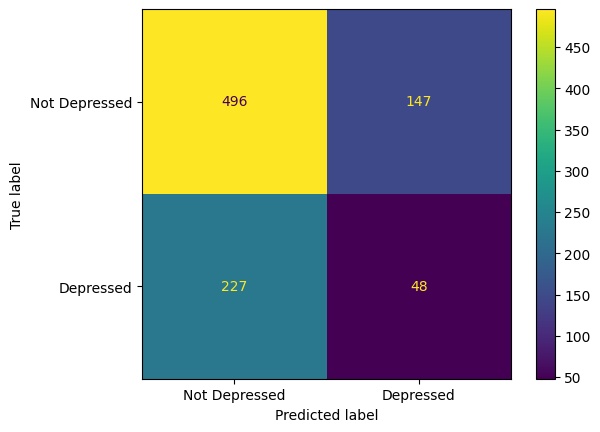

In [ ]:
preds = [1 if row['predicted_label'] == 'Depressed' else 0 for row in lora_model_test_results]
true_labels = [1 if row['true_label'] == 'Depressed' else 0 for row in lora_model_test_results]
eval_model(preds, true_labels, ['Not Depressed','Depressed'])

## Fine tune for a second epoch with cosine scheduler

Note: I ran this training starting at the checkpoint from the previous run. The checkpoint was saved at the end of the first epoch, so this run was trained with 2 total epochs, one with a linear scheduler and one with the cosine scheduler.
Note 2: I cleared the output here since it had a lot of logging messages. I had the logging saved in training_log_20241208_063755.txt

In [ ]:
logging.getLogger("transformers.models.whisper.feature_extraction_whisper").setLevel(logging.ERROR)

# Train the model
trainer = train_model(model, train_loader, val_loader, num_epochs=2, output_dir="/workspace/lora_model_2", lr_scheduler_type="cosine")

# Save the LoRA weights
trainer.model.save_pretrained("/workspace/lora_model_2")

In [ ]:
# Load fresh model and add adaptor onto it
clear_memory()
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-Audio-7B-Instruct")
model = Qwen2AudioForConditionalGeneration.from_pretrained(
        "Qwen/Qwen2-Audio-7B-Instruct",
        torch_dtype=torch.float16,
    ).to(device="cuda")

adapter_path = "/workspace/lora_model_2"
model.load_adapter(adapter_path, "lora2")
model.eval()

In [ ]:
# test fine tuned model on test set
logging.getLogger("transformers.models.whisper.feature_extraction_whisper").setLevel(logging.ERROR)
parent_dir = "/workspace/storage/"
lora2_model_test_results = []

for i, row in test_data.iterrows():
  audio_path = parent_dir + row["Audio Path"]
  true_label = row["Output Label"]

  conversation = [
      {'role': 'system', 'content': 'You are a helpful assistant.'},
      {"role": "user", "content": [
          {"type": "audio", "audio_url": audio_path},  # Using local file path
          {"type": "text", "text": "Based on the audio, is the person depressed? Answer with either \"Depressed\" or \"Not Depressed\"."},
      ]},
  ]
  text = processor.apply_chat_template(conversation, add_generation_prompt=True, tokenize=False)
  audios = []
  for message in conversation:
      if isinstance(message["content"], list):
          for ele in message["content"]:
              if ele["type"] == "audio":
                  # Load directly from file path instead of URL
                  audios.append(
                      librosa.load(
                          ele['audio_url'],
                          sr=processor.feature_extractor.sampling_rate)[0]
                  )

  inputs = processor(text=text, audios=audios, return_tensors="pt", padding=True)
  inputs = {k: v.to("cuda") if hasattr(v, "to") else v for k, v in inputs.items()}

  generate_ids = model.generate(**inputs, max_length=256)
  generate_ids = generate_ids[:, inputs['input_ids'].size(1):]

  response = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
  lora2_model_test_results.append({'true_label': true_label, 'predicted_label': response, 'audio_path': audio_path})

#lora2_model_test_results

Accuracy: 0.5904139433551199
AUC Score: 0.4547603562844621
F1 Score: 0.14545454545454545
Recall: 0.11636363636363636


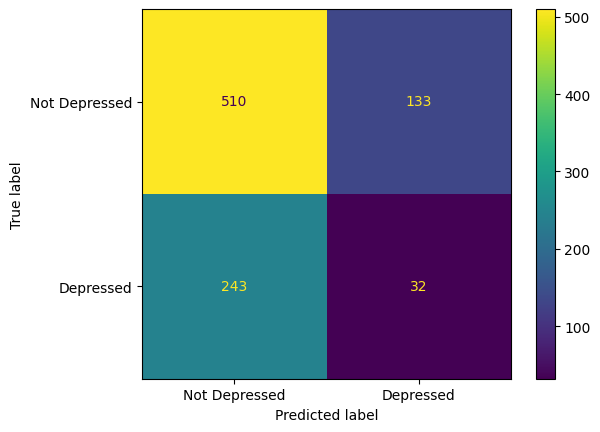

In [ ]:
preds = [1 if row['predicted_label'] == 'Depressed' else 0 for row in lora2_model_test_results]
true_labels = [1 if row['true_label'] == 'Depressed' else 0 for row in lora2_model_test_results]
eval_model(preds, true_labels, ['Not Depressed','Depressed'])

In [ ]:
2